# User Lifecycle plots
Plotting user lifecycle and acculturation gap for subreddits (Figure 6)

In [2]:
import os

os.chdir('/homes/gws/taugust/Projects/ARK/community_guidelines')

%run Reddit/SRILM_building_funcs.ipynb

/homes/gws/taugust/Projects/ARK/community_guidelines


In [2]:
subs = ['science']
comment_slms = {}
post_slms = {}
for i, s in enumerate(subs):
    print('-----------------------------------------------')
    print('Gettting SRILM SLMs for ', colored(s, 'magenta'))
    print('-----------------------------------------------')
    comment_slms[s] = build_monthly_SLM_SRILM(None, None, 10, name=s, use_saved_lms=True, kind='comment', year='2018', full=False)
    post_slms[s] = build_total_SLM_SRILM(None, None, 10, name=s, use_saved_lms=True, kind='post', year='2018', full=False)



-----------------------------------------------
Gettting SRILM SLMs for  science
-----------------------------------------------


In [3]:
comment_slms

{'science': {1: ['../srilms_LMs/2018/comment/science/science_0_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_1_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_2_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_3_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_4_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_5_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_6_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_7_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_8_month_1_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_9_month_1_comment_vocab_60k.lm'],
  2: ['../srilms_LMs/2018/comment/science/science_0_month_2_comment_vocab_60k.lm',
   '../srilms_LMs/2018/comment/science/science_1_month_2_comment_vocab_60k.lm',
   '../srilms_LMs/2018

# User lifecycle 


In [4]:
df_comments, df_posts, df_author_counts_test = get_df_posts_and_comments('science', '2018')

df_author_counts_test_comments = df_author_counts_test[df_author_counts_test['kind'] == 'comment'].copy()
df_author_counts_test_posts = df_author_counts_test[df_author_counts_test['kind'] == 'post'].copy()
df_author_counts_test_comments['total'] = df_author_counts_test_comments[[str(m) for m in range(1,13)]].sum(axis=1)
df_author_counts_test_posts['total'] = df_author_counts_test_posts[[str(m) for m in range(1,13)]].sum(axis=1)

authors = []
for m in range(1,13):
    authors.extend(get_active_users(df_author_counts_test_comments, month=str(m), author_col='author', num_authors=None, kind='comment'))
    
# remove duplicates
authors = list(set(authors))

# select only a subset so we can actually run this
sampled_authors = random.choices(authors, k=1000)

    
df_comments_test = df_comments[df_comments.author.isin(sampled_authors)]

df_posts_test = df_posts[df_posts.author.isin(df_author_counts_test_posts['author'])]

Importing  data/cleaned/sub_comments/science_comments_2018.csv ..... Done
Importing  data/cleaned/test/2018/author_counts/science_author_counts_test_2018.csv ..... Done
Importing  data/cleaned/sub_posts/science_posts_2018.csv ..... Done
Importing  data/cleaned/test/2018/author_counts/science_author_counts_test_2018.csv ..... Done


In [5]:
len(df_comments_test)

15907

In [6]:
# Take people with over n posts
def get_total_active_user(author_df, kind, threshold):
    author_df = author_df[author_df['kind'] == kind]
    # get total number of user posts
    for_months = [str(i) for i in range(1,13)]
    author_df['total'] = author_df[for_months].sum(axis=1, numeric_only=True)
    return author_df[author_df['total'] > threshold]

def get_SRILM_SLM_entropy_single_text(line, slms):
    # make random name, since this will be stored in tmp and doesn't really matter 
    name = str(uuid.uuid4())
    line_path = export_text([line], name=name, corpus_path='/tmp/')
    entropy = calc_month_entropy_SRILM(slms, line_path)
    return entropy

# Get entropy for each line in df, this takes a long time
def get_df_entropy(df, slms, kind):
    df['text'] = [word_tokenize(x)[:10] for x in df.body]
    if kind == 'post':
        df['entropy'] = [get_SRILM_SLM_entropy_single_text(row['text'], slms) for index, row in df.iterrows()]
    else:
        df['entropy'] = [get_SRILM_SLM_entropy_single_text(row['text'], slms[row['created_month']]) for index, row in df.iterrows()]
    df['mean_entropy'] = [np.mean(x) for x in df['entropy'].copy()]
    return df

# get the number of the post/comment that each user has made
def get_df_number(df):
    df['number'] = None
    for a in df['author']:
        df_author = df[df['author'] == a]
        df.loc[df['author'] == a, 'number'] = pd.Series([i for i in range(len(df_author))], index=df_author.sort_values(by='created_utc').index).copy()

    return df



In [7]:

df_comments_test = get_df_entropy(df_comments_test, comment_slms['science'], kind='comment')
df_comments_test = get_df_number(df_comments_test)


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


KeyboardInterrupt: 

In [4]:
# # save the data so you don't have to do the above every time
# # df_posts_test.to_csv('data/cleaned/User_lifecycle_comments_active_vocab_based.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
# df_posts_test = pd.read_csv('data/cleaned/User_lifecycle_posts.csv', quoting=csv.QUOTE_ALL, escapechar='\\')

In [5]:
# save the data so you don't have to do the above every time
# df_comments_test.to_csv('data/cleaned/User_lifecycle_comments.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
df_comments_test = pd.read_csv('data/cleaned/User_lifecycle_comments.csv', quoting=csv.QUOTE_ALL, escapechar='\\')

In [6]:
(df_comments_test[df_comments_test['number'] > 50]['author'].nunique())/(df_comments_test['author'].nunique())

0.0027731558513588465

In [7]:
df_comments_test = df_comments_test[df_comments_test['number'] <= 50]

In [8]:
df_comments_test[['mean_entropy', 'number']].corr(method='pearson')

,mean_entropy,number
mean_entropy,1.000000,-0.032535
number,-0.032535,1.000000


In [9]:
stats.spearmanr(df_comments_test['mean_entropy'], df_comments_test['number'])

SpearmanrResult(correlation=-0.056597199945023303, pvalue=4.0478249606788656e-05)

In [10]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

mod = smf.ols(formula='mean_entropy ~ number', data=df_comments_test[df_comments_test['number'] < 50])

res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_entropy   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.340
Date:                Fri, 06 Mar 2020   Prob (F-statistic):             0.0209
Time:                        14:47:48   Log-Likelihood:                -7613.0
No. Observations:                5249   AIC:                         1.523e+04
Df Residuals:                    5247   BIC:                         1.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2978      0.017    439.895      0.000       7.265       7.330
number        -0.0041      0.002     -2.311      0.021      -0.008      -0.001
==============================================================================
Omnibus:                       80.591   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.966
Skew:                          -0.308   Prob(JB):                     5.85e-19
Kurtosis:                       3.071   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

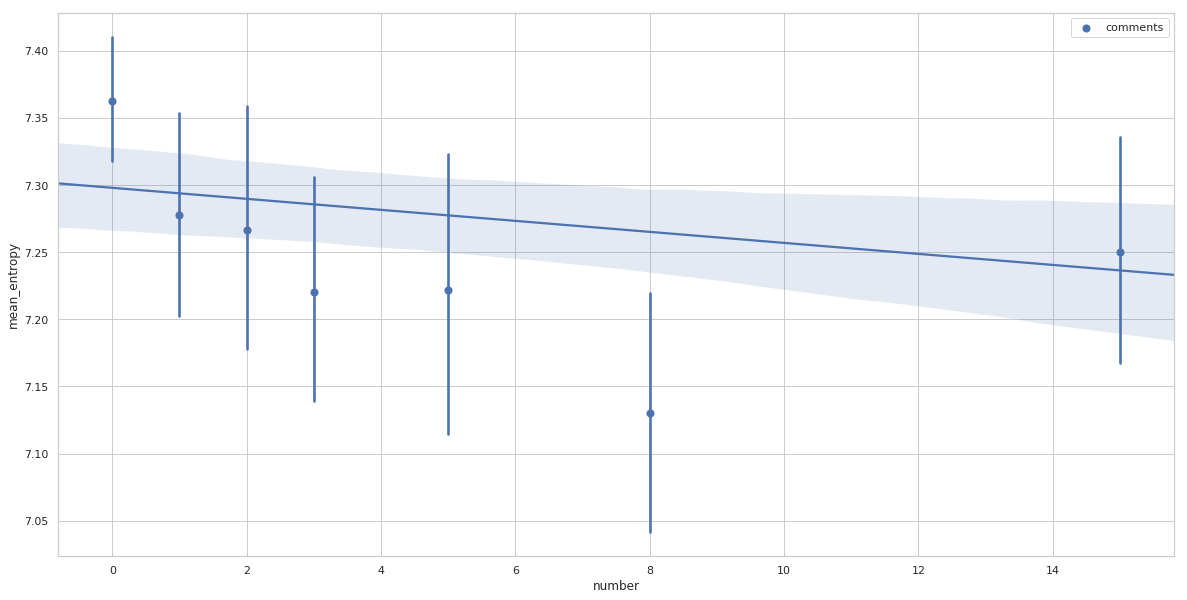

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
# ax = sns.regplot(x="number", y="mean_entropy", x_bins=10, data=df_posts_test[df_posts_test['number'] < 50], x_jitter=.01, label='posts')
ax = sns.regplot(x="number", y="mean_entropy", x_bins=10, data=df_comments_test[df_comments_test['number'] <= 50], x_jitter=.01, label='comments')

ax.legend()